In [47]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from joblib import dump, load

seed = 1
numpy.random.seed(seed)

plt.rcParams['figure.figsize'] = [15, 7]

In [48]:
dataframe = pd.read_csv("kinematics.csv")
dataframe.head()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
0,5.688871,3.023907,6.132910,3.793856,1.459320,1.130452,-0.879452,1.451203,1.197709,-0.874889
1,8.260105,3.302519,7.890928,2.223521,3.598282,0.543488,1.002319,3.582669,0.575476,0.993764
2,2.902297,5.726115,3.923141,6.305244,-1.531685,1.159826,-1.165682,-1.522817,1.226173,-1.161284
3,3.144370,7.120499,1.856136,6.652795,-2.565765,1.555734,1.079061,-2.550903,1.621310,1.073637
4,5.445840,4.244703,5.915291,4.832287,0.731094,0.019866,-0.892686,0.727479,0.066620,-0.888915


In [49]:
dataframe.describe()

,c1,c2,c3,c4,x,y,z,tx,ty,tz
count,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000,6586.000000
mean,4.856314,4.789614,4.856562,4.792569,0.038507,0.951133,-0.003338,0.038293,1.013128,-0.003324
std,1.762342,1.771031,1.767311,1.768667,2.132226,0.545691,0.696080,2.121510,0.563010,0.691953
min,0.874471,0.943208,0.850195,1.059861,-3.715569,0.000066,-1.208912,-3.698177,0.034325,-1.199910
25%,3.373694,3.302781,3.380300,3.282992,-1.806051,0.481343,-0.605661,-1.795949,0.528657,-0.601617
50%,4.768902,4.625168,4.772391,4.633700,0.079340,0.959613,0.003819,0.078895,1.014518,0.003787
75%,6.355075,6.259852,6.356266,6.298601,1.877922,1.424327,0.595221,1.867195,1.495973,0.591902
max,8.424348,8.481502,8.383397,8.478464,3.715328,1.943968,1.211226,3.698786,2.000000,1.198623


In [50]:
X=pd.DataFrame()
X["x"] = dataframe["x"]
X["y"] = dataframe["y"]
X["z"] = dataframe["z"]
X.head()

,x,y,z
0,1.459320,1.130452,-0.879452
1,3.598282,0.543488,1.002319
2,-1.531685,1.159826,-1.165682
3,-2.565765,1.555734,1.079061
4,0.731094,0.019866,-0.892686


In [51]:
Y=pd.DataFrame()
Y["tx"] = dataframe["tx"]-dataframe["x"]
Y["ty"] = dataframe["ty"]-dataframe["y"]
Y["tz"] = dataframe["tz"]-dataframe["z"]
Y.head()

,tx,ty,tz
0,-0.008117,0.067257,0.004563
1,-0.015613,0.031988,-0.008555
2,0.008868,0.066347,0.004398
3,0.014862,0.065576,-0.005424
4,-0.003615,0.046754,0.003771


In [52]:
err=mean_squared_error(np.zeros(Y.shape),Y)
print(err)

0.0015017290336301334


In [54]:


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dump(scaler, 'sim_scaler.joblib') 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.7, random_state=seed)
y_train.describe()

,tx,ty,tz
count,1975.000000,1975.000000,1975.000000
mean,-0.000331,0.061570,0.000080
std,0.010754,0.022310,0.004465
min,-0.018811,0.030307,-0.016219
25%,-0.010196,0.045990,-0.003630
50%,-0.000835,0.055231,-0.000134
75%,0.009785,0.071519,0.003865
max,0.019108,0.146002,0.015904


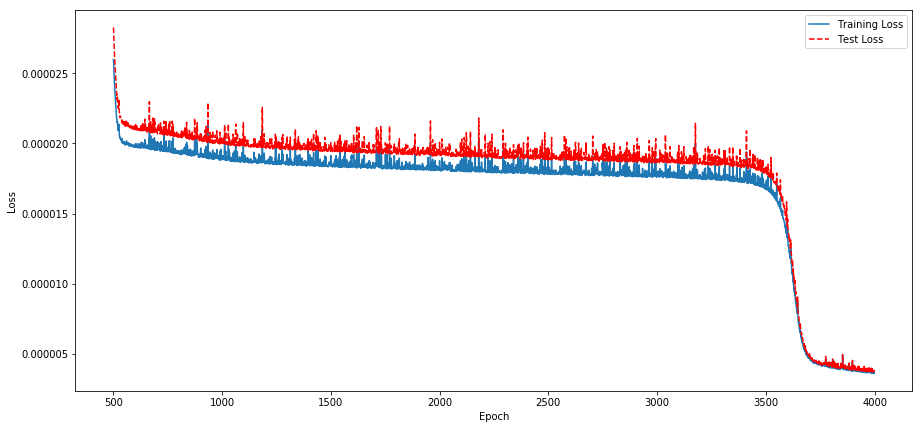

[3.743356180901814e-06, 3.7045706217266163e-06, 3.763701188391159e-06, 3.833909062523962e-06]


In [55]:
def baseline_model(activation='sigmoid'):
    model = Sequential()
    model.add(Dense(8, input_dim=3, kernel_initializer='normal', activation=activation))
    model.add(Dense(3, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    return model

fromepochs=500
toepochs=4000

model = baseline_model(activation='sigmoid')

def train(ep):
    model.fit(X_train,y_train,epochs=1,batch_size=300, verbose=0)
    pred1=model.predict(X_train)
    pred2=model.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    return err1,err2
plt_err1=[]
plt_err2=[]
epch=[]
for ep in range(1,toepochs):
    err1,err2=train(ep)
    plt_err1.append(err1)
    plt_err2.append(err2)
    epch.append(ep)
 
plt.plot(epch[fromepochs:toepochs],plt_err1[fromepochs:toepochs],label="Training Loss")
plt.plot(epch[fromepochs:toepochs],plt_err2[fromepochs:toepochs],'r--',label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(plt_err2[-5:-1])
#with scaling [3.743356180901814e-06, 3.7045706217266163e-06, 3.763701188391159e-06, 3.833909062523962e-06]
#without scaling 1.8256143406378474e-05, 1.833497905008475e-05, 2.080080651703239e-05, 1.9086871143471863e-05

In [56]:
model = baseline_model()
model.fit(X,Y,epochs=50,batch_size=110, verbose=0)
model.save('sim_model.h5')
pred=model.predict(X)
err=mean_squared_error(np.zeros(Y.shape),Y)
print('{:.10f}'.format(err))
err=mean_squared_error(pred,Y)
print('{:.10f}'.format(err))

0.0015017290
0.0000218612


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 7)                 28        
_________________________________________________________________
dropout_4 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 24        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [4]:
import keras

from keras import backend as K
K.clear_session()

import numpy as np
model = keras.models.load_model('/Users/aydarakhmetzyanov/Cable-Component-master/inverse_simulation_model.h5')

Xnew=[]
Xnew.append(2.870216)
Xnew.append(1.432516)
Xnew.append(-0.047003)
XX=[]
XX.append(Xnew)

model.predict(np.array(XX))

array([[-0.00775988,  0.06723656, -0.00038604]], dtype=float32)